# Top

In [1]:
#!pip install transformers
#!pip install datasets

#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from transformers import RobertaModel, RobertaTokenizer, AdamW

from tqdm.auto import tqdm

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

import random
import numpy as np

cur_dir = "/data/users/kashrest/socialiqa-nlp244" #"/content/drive/MyDrive/Colab_Notebooks/NLP_244_Advanced_ML/final_project_socialiqa/socialiqa-nlp244"
data_dir_siqa = "socialiqa-train-dev"
data_dir_hs = "hellaswag-train-dev"
data_dir_anli = "alphanli-train-dev"

out_dir = "out"

np_seed = np.random.seed(27)
torch.manual_seed(27)
random.seed(27)

# Data

## Extract aNLI data

Getting data and corresponding labels from dev and train split


In [3]:
file_train_anli = os.path.join(cur_dir, data_dir_anli, "train.jsonl")
file_dev_anli = os.path.join(cur_dir, data_dir_anli, "dev.jsonl")

json_train_anli = pd.read_json(file_train_anli, lines=True)
json_dev_anli = pd.read_json(file_dev_anli, lines=True)

# list of tuples (obs1, obs2, hyp1, hyp2)
train_data_anli = [elem for elem in zip(json_train_anli['obs1'].tolist(), 
                                   json_train_anli['obs2'].tolist(), 
                                   json_train_anli['hyp1'].tolist(), 
                                   json_train_anli['hyp2'].tolist())]

dev_data_anli = [elem for elem in zip(json_dev_anli['obs1'].tolist(), 
                                   json_dev_anli['obs2'].tolist(), 
                                   json_dev_anli['hyp1'].tolist(), 
                                   json_dev_anli['hyp2'].tolist())]

print(len(train_data_anli), len(dev_data_anli))

# Labels is a list of integers either 0, 1
train_labels_anli = []
dev_labels_anli = []
with open(os.path.join(cur_dir, data_dir_anli, "train-labels.lst")) as f:
    for line in f:
      train_labels_anli.append(int(line.split()[0]))

with open(os.path.join(cur_dir, data_dir_anli, "dev-labels.lst")) as f:
    for line in f:
      dev_labels_anli.append(int(line.split()[0]))

train_labels_anli = [label-1 for label in train_labels_anli]
dev_labels_anli = [label-1 for label in dev_labels_anli]

print(len(train_labels_anli), len(dev_labels_anli))

169654 1532
169654 1532


In [4]:
class aNliDataset(Dataset):
    """
    This dataset class is for preparing data for aNLI.

    This is the context/question + multiple choice format, and each example
    consists of num choices lists of encoded strings. Note that the input will
    be encoded and padded in this stage. prepare_batch will take care of padding 
    across examples in the batch-level. 
    """
    def __init__(self, tokenizer, x, y):
        # x: list of tuples containing (obs1, obs2, hyp1, hyp2)
        # y: list of indices of the correct answer
        self.roberta_tokenizer = tokenizer
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        point = self.x[idx]
        # format for aNLI is: obs1 hyp1 obs 2, obs1 hyp2 obs2
        input_context_question = [point[0] + self.roberta_tokenizer.sep_token + self.roberta_tokenizer.sep_token + point[2], point[0] + self.roberta_tokenizer.sep_token + self.roberta_tokenizer.sep_token + point[3]]
        input_answers = [point[1], point[1]]
        encoded_text_train = self.roberta_tokenizer(input_context_question, input_answers, return_tensors='pt', padding=True)
        return (encoded_text_train, self.y[idx])

    def __len__(self):
        return len(self.x)


## Extract HellaSwag data

Getting data and corresponding labels from dev and train split

In [5]:
file_train_hs = os.path.join(cur_dir, data_dir_hs, "train.jsonl")
file_dev_hs = os.path.join(cur_dir, data_dir_hs, "valid.jsonl")

json_train_hs = pd.read_json(path_or_buf=file_train_hs, lines=True)
json_dev_hs = pd.read_json(path_or_buf=file_dev_hs, lines=True)

# list of tuples (context, 
#                [ending option 1, 
#                 ending option 2, 
#                 ending option 3, 
#                 ending option 4])
train_data_hs = [elem for elem in zip(json_train_hs['ctx'].tolist(), 
                                   json_train_hs['ending_options'].tolist())]

dev_data_hs = [elem for elem in zip(json_dev_hs['ctx'].tolist(), 
                                   json_dev_hs['ending_options'].tolist())]

print(len(train_data_hs), len(dev_data_hs))

# Labels is a list of integers either 0, 1, 2, 3
train_labels_hs = []
dev_labels_hs = []
with open(os.path.join(cur_dir, data_dir_hs, "train-labels.lst")) as f:
    for line in f:
      train_labels_hs.append(int(line.split()[0]))

with open(os.path.join(cur_dir, data_dir_hs, "valid-labels.lst")) as f:
    for line in f:
      dev_labels_hs.append(int(line.split()[0]))

train_labels_hs = [label for label in train_labels_hs]
dev_labels_hs = [label for label in dev_labels_hs]

print(len(train_labels_hs), len(dev_labels_hs))

39905 10042
39905 10042


In [6]:
class HellaSwagDataset(Dataset):
    """
    This dataset class is for preparing data for HellaSwag.

    This is the context + multiple choice format, and each example
    consists of num choices lists of encoded strings. Note that the input will
    be encoded and padded in this stage. prepare_batch will take care of padding 
    across examples in the batch-level. 
    """
    def __init__(self, tokenizer, x, y):
        # x: list of tuples containing (context, 
        #                               [ending option 1, 
        #                                ending option 2, 
        #                                ending option 3, 
        #                                ending option 4])
        # y: list of indices of the correct answer 0, 1, 2, or 3
        self.roberta_tokenizer = tokenizer
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        point = self.x[idx]
        input_context = [point[0], point[0], point[0], point[0]]
        input_answers = [point[1][0], point[1][1], point[1][2], point[1][3]]
        encoded_text_train = self.roberta_tokenizer(input_context, input_answers, return_tensors='pt', padding=True)
        return (encoded_text_train, self.y[idx])

    def __len__(self):
        return len(self.x)


## Extract SocialIQA data

Getting data and corresponding labels from dev and train split

In [7]:
file_train_siqa = os.path.join(cur_dir, data_dir_siqa, "train.jsonl")
file_dev_siqa = os.path.join(cur_dir, data_dir_siqa, "dev.jsonl")

json_train = pd.read_json(path_or_buf=file_train_siqa, lines=True)
json_dev = pd.read_json(path_or_buf=file_dev_siqa, lines=True)

# Data is a list of tuples (context, question, A, B, C)
train_data_siqa = [elem for elem in zip(json_train['context'].tolist(), 
                                   json_train['question'].tolist(), 
                                   json_train['answerA'].tolist(), 
                                   json_train['answerB'].tolist(), 
                                   json_train['answerC'].tolist())]

dev_data_siqa = [elem for elem in zip(json_dev['context'].tolist(), 
                                   json_dev['question'].tolist(), 
                                   json_dev['answerA'].tolist(), 
                                   json_dev['answerB'].tolist(), 
                                   json_dev['answerC'].tolist())]

print(len(train_data_siqa), len(dev_data_siqa))

# Labels is a list of integers either 0, 1, 2
train_labels_siqa = []
dev_labels_siqa = []
with open(os.path.join(cur_dir, data_dir_siqa, "train-labels.lst")) as f:
    for line in f:
      train_labels_siqa.append(int(line.split()[0]))

with open(os.path.join(cur_dir, data_dir_siqa, "dev-labels.lst")) as f:
    for line in f:
      dev_labels_siqa.append(int(line.split()[0]))

train_labels_siqa = [label-1 for label in train_labels_siqa]
dev_labels_siqa = [label-1 for label in dev_labels_siqa]

print(len(train_labels_siqa), len(dev_labels_siqa))

33410 1954
33410 1954


In [8]:
class SocialiqaDataset(Dataset):
    """
    This dataset class is for preparing data for socialiqa.

    This is the context/question + multiple choice format, and each example
    consists of num choices lists of encoded strings. Note that the input will
    be encoded and padded in this stage. prepare_batch will take care of padding 
    across examples in the batch-level. 
    """
    def __init__(self, tokenizer, x, y):
        # x: list of tuples containing (context, question, answer1, answer2, answer3)
        # y: list of indices of the correct answer
        self.roberta_tokenizer = tokenizer
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        point = self.x[idx]
        input_context_question = [point[0] + self.roberta_tokenizer.sep_token + self.roberta_tokenizer.sep_token + point[1], point[0] + self.roberta_tokenizer.sep_token + self.roberta_tokenizer.sep_token + point[1], point[0] + self.roberta_tokenizer.sep_token + self.roberta_tokenizer.sep_token + point[1]]
        input_answers = [point[2], point[3], point[4]]
        encoded_text_train = self.roberta_tokenizer(input_context_question, input_answers, return_tensors='pt', padding=True)
        return (encoded_text_train, self.y[idx])

    def __len__(self):
        return len(self.x)


## Prepare batch MC (all)

In [9]:
def prepare_batch_MC(batch, tokenizer):
    """
    This collate function will pad the batch to be the same length. This requires
    flattening, then unflattening for the multiple choice format.
    One example will be a list of length 'num choices', each element being a list
    of (encoded) tokens representing qustion/answer [sep] choicex
    """
    # batch: [batch_size, (text, label)]
    batch_size = len(batch)

    features, labels = zip(*batch)
    # features: tuple of length batch_size, 
    #        each element is a dict with keys = ["input_ids", "attention_mask"]
    # labels: tuple of int indicies length batch_size
    num_choices = len(features[0]["input_ids"])
    
    # flatten
    flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
    flattened_features = sum(flattened_features, [])
    # flattened_features list length num_choices*batch_size

    batch = tokenizer.pad(
            flattened_features,
            padding=True,
            return_tensors="pt",
        )
    
    # Un-flatten
    batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
    return (batch, torch.tensor(labels, dtype=torch.int64))


# Model Class and Training Class

In [10]:
class Multiple_Choice_Model(nn.Module):
    def __init__(self, roberta_model: RobertaModel, dropout: float = None):
          super(Multiple_Choice_Model, self).__init__()
          self.roberta = roberta_model
          self.dropout = nn.Dropout(self.roberta.config.hidden_dropout_prob)
          self.classifier = nn.Linear(self.roberta.config.hidden_size, 1)
   
    def forward(self, input_ids: torch.tensor, attention_mask: torch.tensor, labels=None):
          num_choices = input_ids.shape[1] 
          flat_input_ids = input_ids.view(-1, input_ids.size(-1))
          flat_attention_mask = attention_mask.view(-1, attention_mask.size(-1))

          outputs = self.roberta(
              input_ids = flat_input_ids,
              attention_mask=flat_attention_mask,
          )
          pooled_output = outputs[1] 

          pooled_output = self.dropout(pooled_output)
          logits = self.classifier(pooled_output)
          reshaped_logits = logits.view(-1, num_choices)

          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(reshaped_logits, labels)

          return loss, reshaped_logits

In [11]:
from sklearn.metrics import classification_report

class Trainer(object):
    """
    Trainer for training a multiple choice classification model
    """

    def __init__(self, model, optimizer, device="cpu"):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device

    def _print_summary(self):
        print(self.model)
        print(self.optimizer)

    def train(self, loader):
        """
        Run a single epoch of training
        """

        self.model.train() # Run model in training mode
        loss = None

        epoch_true_labels = []
        epoch_preds = []
        for i, batch in tqdm(enumerate(loader)):
            # clear gradient
            self.optimizer.zero_grad() 
            # input_ids shape: (batch_size, num_choices, sequence_length)
            input_ids = batch[0]['input_ids'].to(self.device)
            # input_ids shape: (batch_size, num_choices, sequence_length)
            attention_mask = batch[0]['attention_mask'].to(self.device)
            # labels shape: (batch_size, )
            labels = batch[1].to(self.device)

            outputs = self.model(input_ids=input_ids, 
                            attention_mask=attention_mask,
                            labels=labels)
            loss, logits = outputs[0], outputs[1]
            
            epoch_true_labels.extend(labels.tolist())
            epoch_preds.extend(torch.argmax(nn.Softmax(dim=1)(logits), dim=1).tolist())
            
            # back propagation
            loss.backward()
            # do gradient descent
            self.optimizer.step() 

        # Just returning the last loss
        return loss, epoch_true_labels, epoch_preds

    def evaluate(self, loader):
        """
        Evaluate the model on a validation set.
        Only do batch size = 1.
        """

        self.model.eval() # Run model in eval mode (disables dropout layer)
        loss = None

        epoch_true_labels = []
        epoch_preds = []
        with torch.no_grad(): # Disable gradient computation - required only during training
            for i, batch in tqdm(enumerate(loader)):
                # input_ids shape: (batch_size, num_choices, sequence_length)
                input_ids = batch[0]['input_ids'].to(self.device)
                # input_ids shape: (batch_size, num_choices, sequence_length)
                attention_mask = batch[0]['attention_mask'].to(self.device)
                # labels shape: (batch_size, )
                labels = batch[1].to(self.device)

                outputs = self.model(input_ids=input_ids, 
                                attention_mask=attention_mask,
                                labels=labels)
                loss, logits = outputs[0], outputs[1]
                
                epoch_true_labels.extend(labels.tolist())
                epoch_preds.extend(torch.argmax(nn.Softmax(dim=1)(logits), dim=1).tolist())
            
        # Just returning the last loss
        return loss, epoch_true_labels, epoch_preds

    def get_model_dict(self):
        return self.model.state_dict()

    def run_training(self, train_loader, valid_loader, save_location, dataset, n_epochs=3):
        # Useful for us to review what experiment we're running
        # Normally, you'd want to save this to a file
        # self._print_summary()
        losses_valid = []
        losses_train = []
        best_valid = float("inf")
        for i in range(n_epochs):
            target_names = None
            if dataset == 'hs':
                target_names = ['Ending Option 1', 'Ending Option 2', 'Ending Option 3', 'Ending Option 4']
            elif dataset == 'siqa':
                target_names = ['Answer A', 'Answer B', 'Answer C']
            elif dataset == 'anli':
                target_names = ['Hypothesis 1', 'Hypothesis 2']
            
            epoch_loss_train, labels, preds = self.train(train_loader)
            print("Train eval")
            print(classification_report(labels, preds, target_names=target_names))

            epoch_loss_valid, labels, preds = self.evaluate(valid_loader)
            print("Valid eval")
            print(classification_report(labels, preds, target_names=target_names))


            if epoch_loss_valid < best_valid:
                best_valid = epoch_loss_valid
                torch.save(self.get_model_dict(), os.path.join(cur_dir, out_dir, save_location, f'model-mc-checkpoint-epoch{i+1}.pt'))
            
            losses_train.append(epoch_loss_train.tolist())
            losses_valid.append(epoch_loss_valid.tolist())
            print(f"Epoch {i}")
            print(f"Train loss: {epoch_loss_train}")
            print(f"Valid loss: {epoch_loss_valid}")

        train_epoch_idx = range(len(losses_train))
        valid_epoch_idx = range(len(losses_valid))
        # sns.lineplot(epoch_idx, all_losses)
        sns.lineplot(train_epoch_idx, losses_train)
        sns.lineplot(valid_epoch_idx, losses_valid)
        plt.show()

# Phase 1: Knowledge Graph Pretraining

In [ ]:
!python run_mlm.py \
    --model_name_or_path roberta-base \
    --line_by_line \
    --train_file conceptnet_sentences.txt \
    --save_strategy "epoch" \
    --num_train_epochs 3 \
    --do_train \
    --learning_rate 1e-5 \
    --output_dir out/roberta-mlm-conceptnet/

This is how to load the roberta model trained with MLM on ConceptNet, for example

In [ ]:
# roberta_base = RobertaModel.from_pretrained(os.path.join(cur_dir, out_dir, "roberta-mlm-conceptnet"))
roberta_base = RobertaModel.from_pretrained(os.path.join(cur_dir, out_dir, "roberta-mlm-atomic"))

RobertaTokenizer.from_pretrained('roberta-base')
mc_model_pretrained_mlm = Multiple_Choice_Model(roberta_base)

# Phase 2

## Experiment 1: Training on HellaSwag first

Setting up model hyperparameters

In [ ]:
#********************SET HYPERPARAMTERS*********************************
TRAIN_BATCH_SIZE = 8
ADAM_LEARNING_RATE = 5e-6
NUM_EPOCHS = 10

# This is the base roberta class that will be pretrained on various different tasks

# This is the base roberta class that will be pretrained on various different tasks
roberta_base = RobertaModel.from_pretrained(os.path.join(cur_dir, out_dir, "roberta-mlm-conceptnet")) # pretrained on ConceptNet
# roberta_base = RobertaModel.from_pretrained(os.path.join(cur_dir, out_dir, "roberta-mlm-atomic")) # pretrained on ATOMIC

mc_model_hs = Multiple_Choice_Model(roberta_base)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
OPTIMIZER = AdamW(mc_model_hs.parameters(), lr=ADAM_LEARNING_RATE)

#********************DATA*******************************
train_loader_hs = DataLoader(HellaSwagDataset(tokenizer, train_data_hs, train_labels_hs), 
                             batch_size=TRAIN_BATCH_SIZE, 
                             shuffle=True, 
                             collate_fn=lambda batch: prepare_batch_MC(batch, tokenizer))
val_loader_hs = DataLoader(HellaSwagDataset(tokenizer, dev_data_hs, dev_labels_hs), 
                           batch_size=1, 
                           shuffle=False)

#********************SET UP AND RUN TRAINING*******************************
trainer_hs = Trainer(mc_model_hs, OPTIMIZER, DEVICE)
trainer_hs.run_training(train_loader_hs, val_loader_hs, save_location='roberta-pretrain-hellaswag-batch-size-8-lr-5e-6', dataset='hs', n_epochs=NUM_EPOCHS)

## Experiment 2: Training on aNLI first

In [ ]:
#********************SET HYPERPARAMTERS*********************************
TRAIN_BATCH_SIZE = 8
ADAM_LEARNING_RATE = 5e-6
NUM_EPOCHS = 10

# This is the base roberta class that will be pretrained on various different tasks
roberta_base = RobertaModel.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
mc_model_anli = Multiple_Choice_Model(roberta_base)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
OPTIMIZER = AdamW(mc_model_anli.parameters(), lr=ADAM_LEARNING_RATE)


#********************DATA*******************************
train_loader_anli = DataLoader(aNliDataset(tokenizer, train_data_anli, train_labels_anli), 
                             batch_size=TRAIN_BATCH_SIZE, 
                             shuffle=True, 
                             collate_fn=lambda batch: prepare_batch_MC(batch, tokenizer))

val_loader_anli = DataLoader(aNliDataset(tokenizer, dev_data_anli, dev_labels_anli), 
                           batch_size=1, 
                           shuffle=False)

#********************SET UP AND RUN TRAINING*******************************
trainer_anli = Trainer(mc_model_anli, OPTIMIZER, DEVICE)
trainer_anli.run_training(train_loader_anli, val_loader_anli, save_location='roberta-pretrain-anli', dataset='anli', n_epochs=NUM_EPOCHS)

## Experiment 3: Training HellaSwag after aNLI (aNLI-->HellaSwag)

In [ ]:
#*********************RESTORE MODEL TRAINED ON aNLI************************
mc_model_anli_restored_state_dict = torch.load(os.path.join(cur_dir, out_dir, "roberta-pretrain-anli", 'model-mc-checkpoint-epoch1.pt'), )

roberta_base = RobertaModel.from_pretrained('roberta-base') # placeholder
mc_model_anli_restored = Multiple_Choice_Model(roberta_base)

# Restore state dict to load the same weights again
mc_model_anli_restored.load_state_dict(mc_model_anli_restored_state_dict)
print("****Model pretrained on aNLI, restored***")

#********************SET HYPERPARAMTERS*********************************
TRAIN_BATCH_SIZE = 8
ADAM_LEARNING_RATE = 1e-5
NUM_EPOCHS = 10
DEVICE = torch.device('cuda:4') if torch.cuda.is_available() else torch.device('cpu')
OPTIMIZER = AdamW(mc_model_anli_restored.parameters(), lr=ADAM_LEARNING_RATE)
print("****Hyperprameters set****")

#********************DATA*******************************
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_loader_hs = DataLoader(HellaSwagDataset(tokenizer, train_data_hs, train_labels_hs), 
                             batch_size=TRAIN_BATCH_SIZE, 
                             shuffle=True, 
                             collate_fn=lambda batch: prepare_batch_MC(batch, tokenizer))

val_loader_hs = DataLoader(HellaSwagDataset(tokenizer, dev_data_hs, dev_labels_hs), 
                           batch_size=1, 
                           shuffle=False)
print("****Data, prepared****")

#********************SET UP AND RUN TRAINING*******************************
trainer_anli_hs = Trainer(mc_model_anli_restored, OPTIMIZER, DEVICE)
print("****Training****")
trainer_anli_hs.run_training(train_loader_hs, val_loader_hs, save_location='roberta-pretrain-hellaswag-after-anli-lr-5e-6', dataset='hs', n_epochs=NUM_EPOCHS)

## Experiment 4: Training aNLI after HellaSwag (HellaSwag-->aNLI)

In [12]:
#*********************RESTORE MODEL TRAINED ON aNLI************************
mc_model_hs_restored_state_dict = torch.load(os.path.join(cur_dir, out_dir, "mlm-conceptnet-atomic-hellaswag", 'model-mc-checkpoint-epoch8.pt'))

roberta_base = RobertaModel.from_pretrained('roberta-base') # placeholder
mc_model_hs_restored = Multiple_Choice_Model(roberta_base)

# Restore state dict to load the same weights again
mc_model_hs_restored.load_state_dict(mc_model_hs_restored_state_dict)
print("****Model pretrained on HellaSwag, restored***")

#********************SET HYPERPARAMTERS*********************************
TRAIN_BATCH_SIZE = 8
ADAM_LEARNING_RATE = 5e-6
NUM_EPOCHS = 10
DEVICE = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')
OPTIMIZER = AdamW(mc_model_hs_restored.parameters(), lr=ADAM_LEARNING_RATE)
print("****Hyperprameters set****")

#********************DATA*******************************
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_loader_anli = DataLoader(aNliDataset(tokenizer, train_data_anli, train_labels_anli), 
                             batch_size=TRAIN_BATCH_SIZE, 
                             shuffle=True, 
                             collate_fn=lambda batch: prepare_batch_MC(batch, tokenizer))

val_loader_anli = DataLoader(aNliDataset(tokenizer, dev_data_anli, dev_labels_anli), 
                           batch_size=1, 
                           shuffle=False)
print("****Data, prepared****")

#********************SET UP AND RUN TRAINING*******************************
trainer_hs_anli = Trainer(mc_model_hs_restored, OPTIMIZER, DEVICE)
print("****Training****")
trainer_hs_anli.run_training(train_loader_anli, val_loader_anli, save_location='mlm-conceptnet-atomic-hellaswag-anli', dataset='anli', n_epochs=NUM_EPOCHS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


****Model pretrained on HellaSwag, restored***
****Hyperprameters set****
****Data, prepared****
****Training****


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

Hypothesis 1       0.90      0.90      0.90     84832
Hypothesis 2       0.90      0.90      0.90     84822

    accuracy                           0.90    169654
   macro avg       0.90      0.90      0.90    169654
weighted avg       0.90      0.90      0.90    169654



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

Hypothesis 1       0.70      0.67      0.68       781
Hypothesis 2       0.67      0.70      0.68       751

    accuracy                           0.68      1532
   macro avg       0.69      0.69      0.68      1532
weighted avg       0.69      0.68      0.68      1532

Epoch 0
Train loss: 0.47903135418891907
Valid loss: 1.262544870376587


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

Hypothesis 1       0.94      0.94      0.94     84832
Hypothesis 2       0.94      0.94      0.94     84822

    accuracy                           0.94    169654
   macro avg       0.94      0.94      0.94    169654
weighted avg       0.94      0.94      0.94    169654



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

Hypothesis 1       0.73      0.68      0.70       781
Hypothesis 2       0.69      0.73      0.71       751

    accuracy                           0.71      1532
   macro avg       0.71      0.71      0.71      1532
weighted avg       0.71      0.71      0.71      1532

Epoch 1
Train loss: 0.0770275890827179
Valid loss: 0.5550674796104431


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

Hypothesis 1       0.96      0.97      0.96     84832
Hypothesis 2       0.97      0.96      0.96     84822

    accuracy                           0.96    169654
   macro avg       0.96      0.96      0.96    169654
weighted avg       0.96      0.96      0.96    169654



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

Hypothesis 1       0.73      0.71      0.72       781
Hypothesis 2       0.71      0.73      0.72       751

    accuracy                           0.72      1532
   macro avg       0.72      0.72      0.72      1532
weighted avg       0.72      0.72      0.72      1532

Epoch 2
Train loss: 0.006976472679525614
Valid loss: 0.9356067180633545


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

Hypothesis 1       0.98      0.98      0.98     84832
Hypothesis 2       0.98      0.98      0.98     84822

    accuracy                           0.98    169654
   macro avg       0.98      0.98      0.98    169654
weighted avg       0.98      0.98      0.98    169654



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

Hypothesis 1       0.73      0.70      0.71       781
Hypothesis 2       0.70      0.72      0.71       751

    accuracy                           0.71      1532
   macro avg       0.71      0.71      0.71      1532
weighted avg       0.71      0.71      0.71      1532

Epoch 3
Train loss: 0.09196402877569199
Valid loss: 1.9143165349960327


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

Hypothesis 1       0.98      0.98      0.98     84832
Hypothesis 2       0.98      0.98      0.98     84822

    accuracy                           0.98    169654
   macro avg       0.98      0.98      0.98    169654
weighted avg       0.98      0.98      0.98    169654



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

Hypothesis 1       0.72      0.71      0.72       781
Hypothesis 2       0.70      0.71      0.71       751

    accuracy                           0.71      1532
   macro avg       0.71      0.71      0.71      1532
weighted avg       0.71      0.71      0.71      1532

Epoch 4
Train loss: 0.024699462577700615
Valid loss: 1.584173560142517


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

Hypothesis 1       0.99      0.99      0.99     84832
Hypothesis 2       0.99      0.99      0.99     84822

    accuracy                           0.99    169654
   macro avg       0.99      0.99      0.99    169654
weighted avg       0.99      0.99      0.99    169654



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

Hypothesis 1       0.74      0.72      0.73       781
Hypothesis 2       0.71      0.73      0.72       751

    accuracy                           0.73      1532
   macro avg       0.73      0.73      0.73      1532
weighted avg       0.73      0.73      0.73      1532

Epoch 5
Train loss: 0.009353837929666042
Valid loss: 0.5899491310119629


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

Hypothesis 1       0.99      0.99      0.99     84832
Hypothesis 2       0.99      0.99      0.99     84822

    accuracy                           0.99    169654
   macro avg       0.99      0.99      0.99    169654
weighted avg       0.99      0.99      0.99    169654



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

Hypothesis 1       0.73      0.71      0.72       781
Hypothesis 2       0.71      0.73      0.72       751

    accuracy                           0.72      1532
   macro avg       0.72      0.72      0.72      1532
weighted avg       0.72      0.72      0.72      1532

Epoch 6
Train loss: 0.0020093785133212805
Valid loss: 4.0615763664245605


0it [00:00, ?it/s]

KeyboardInterrupt: 

# Phase 3: Fine-tuning on SocialIQA

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

    Answer A       0.74      0.73      0.74     11274
    Answer B       0.74      0.73      0.73     11176
    Answer C       0.73      0.74      0.73     10960

    accuracy                           0.73     33410
   macro avg       0.73      0.73      0.73     33410
weighted avg       0.73      0.73      0.73     33410



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

    Answer A       0.71      0.70      0.70       643
    Answer B       0.68      0.67      0.68       654
    Answer C       0.69      0.71      0.70       657

    accuracy                           0.69      1954
   macro avg       0.69      0.69      0.69      1954
weighted avg       0.69      0.69      0.69      1954

Epoch 0
Train loss: 1.4690672159194946
Valid loss: 0.057485926896333694


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

    Answer A       0.81      0.80      0.81     11274
    Answer B       0.81      0.81      0.81     11176
    Answer C       0.80      0.81      0.81     10960

    accuracy                           0.81     33410
   macro avg       0.81      0.81      0.81     33410
weighted avg       0.81      0.81      0.81     33410



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

    Answer A       0.72      0.68      0.70       643
    Answer B       0.72      0.69      0.70       654
    Answer C       0.69      0.75      0.72       657

    accuracy                           0.71      1954
   macro avg       0.71      0.71      0.70      1954
weighted avg       0.71      0.71      0.70      1954

Epoch 1
Train loss: 0.2951711118221283
Valid loss: 0.04557162895798683


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

    Answer A       0.87      0.86      0.87     11274
    Answer B       0.87      0.86      0.86     11176
    Answer C       0.85      0.87      0.86     10960

    accuracy                           0.86     33410
   macro avg       0.86      0.86      0.86     33410
weighted avg       0.86      0.86      0.86     33410



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

    Answer A       0.71      0.70      0.70       643
    Answer B       0.70      0.68      0.69       654
    Answer C       0.68      0.71      0.70       657

    accuracy                           0.70      1954
   macro avg       0.70      0.70      0.70      1954
weighted avg       0.70      0.70      0.70      1954

Epoch 2
Train loss: 1.4108060598373413
Valid loss: 0.0027581527829170227


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

    Answer A       0.91      0.91      0.91     11274
    Answer B       0.91      0.91      0.91     11176
    Answer C       0.91      0.91      0.91     10960

    accuracy                           0.91     33410
   macro avg       0.91      0.91      0.91     33410
weighted avg       0.91      0.91      0.91     33410



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

    Answer A       0.69      0.70      0.69       643
    Answer B       0.71      0.68      0.69       654
    Answer C       0.69      0.70      0.70       657

    accuracy                           0.69      1954
   macro avg       0.69      0.69      0.69      1954
weighted avg       0.69      0.69      0.69      1954

Epoch 3
Train loss: 0.0014188147615641356
Valid loss: 0.00018404220463708043


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

    Answer A       0.94      0.94      0.94     11274
    Answer B       0.94      0.94      0.94     11176
    Answer C       0.94      0.94      0.94     10960

    accuracy                           0.94     33410
   macro avg       0.94      0.94      0.94     33410
weighted avg       0.94      0.94      0.94     33410



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

    Answer A       0.71      0.69      0.70       643
    Answer B       0.69      0.69      0.69       654
    Answer C       0.69      0.71      0.70       657

    accuracy                           0.70      1954
   macro avg       0.70      0.70      0.70      1954
weighted avg       0.70      0.70      0.70      1954

Epoch 4
Train loss: 1.5170631408691406
Valid loss: 7.760223525110632e-05


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

    Answer A       0.96      0.96      0.96     11274
    Answer B       0.96      0.96      0.96     11176
    Answer C       0.95      0.95      0.95     10960

    accuracy                           0.96     33410
   macro avg       0.96      0.96      0.96     33410
weighted avg       0.96      0.96      0.96     33410



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

    Answer A       0.68      0.66      0.67       643
    Answer B       0.67      0.66      0.66       654
    Answer C       0.67      0.68      0.67       657

    accuracy                           0.67      1954
   macro avg       0.67      0.67      0.67      1954
weighted avg       0.67      0.67      0.67      1954

Epoch 5
Train loss: 0.048608310520648956
Valid loss: 3.6954811548639555e-06


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

    Answer A       0.97      0.97      0.97     11274
    Answer B       0.97      0.97      0.97     11176
    Answer C       0.96      0.97      0.97     10960

    accuracy                           0.97     33410
   macro avg       0.97      0.97      0.97     33410
weighted avg       0.97      0.97      0.97     33410



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

    Answer A       0.69      0.69      0.69       643
    Answer B       0.68      0.67      0.68       654
    Answer C       0.69      0.70      0.70       657

    accuracy                           0.69      1954
   macro avg       0.69      0.69      0.69      1954
weighted avg       0.69      0.69      0.69      1954

Epoch 6
Train loss: 0.02196503058075905
Valid loss: 0.020466921851038933


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

    Answer A       0.97      0.97      0.97     11274
    Answer B       0.97      0.97      0.97     11176
    Answer C       0.97      0.97      0.97     10960

    accuracy                           0.97     33410
   macro avg       0.97      0.97      0.97     33410
weighted avg       0.97      0.97      0.97     33410



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

    Answer A       0.70      0.70      0.70       643
    Answer B       0.69      0.67      0.68       654
    Answer C       0.69      0.72      0.70       657

    accuracy                           0.69      1954
   macro avg       0.69      0.69      0.69      1954
weighted avg       0.69      0.69      0.69      1954

Epoch 7
Train loss: 0.5365989804267883
Valid loss: 3.576278118089249e-07


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

    Answer A       0.98      0.98      0.98     11274
    Answer B       0.98      0.97      0.98     11176
    Answer C       0.98      0.98      0.98     10960

    accuracy                           0.98     33410
   macro avg       0.98      0.98      0.98     33410
weighted avg       0.98      0.98      0.98     33410



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

    Answer A       0.69      0.69      0.69       643
    Answer B       0.71      0.69      0.70       654
    Answer C       0.69      0.71      0.70       657

    accuracy                           0.70      1954
   macro avg       0.70      0.70      0.70      1954
weighted avg       0.70      0.70      0.70      1954

Epoch 8
Train loss: 0.0035914189647883177
Valid loss: 0.0001618731184862554


0it [00:00, ?it/s]

Train eval
              precision    recall  f1-score   support

    Answer A       0.98      0.98      0.98     11274
    Answer B       0.98      0.98      0.98     11176
    Answer C       0.98      0.98      0.98     10960

    accuracy                           0.98     33410
   macro avg       0.98      0.98      0.98     33410
weighted avg       0.98      0.98      0.98     33410



0it [00:00, ?it/s]

Valid eval
              precision    recall  f1-score   support

    Answer A       0.68      0.70      0.69       643
    Answer B       0.70      0.68      0.69       654
    Answer C       0.69      0.68      0.68       657

    accuracy                           0.69      1954
   macro avg       0.69      0.69      0.69      1954
weighted avg       0.69      0.69      0.69      1954

Epoch 9
Train loss: 0.00019361800514161587
Valid loss: 0.0


/data/users/kashrest/miniconda3/envs/nlp-244/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data/users/kashrest/miniconda3/envs/nlp-244/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


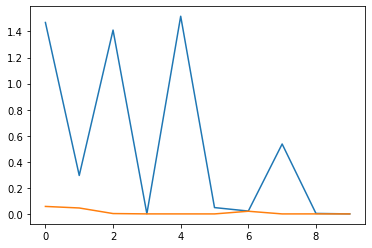

In [12]:
#*********************RESTORE MODEL TRAINED ON aNLI************************
folder = "mlm-conceptnet-atomic-hellaswag-anli"
best_checkpoint = 'model-mc-checkpoint-epoch2.pt'
mc_model_anli_restored_state_dict = torch.load(os.path.join(cur_dir, out_dir, folder, best_checkpoint), )

roberta_base = RobertaModel.from_pretrained('roberta-base') # placeholder
mc_model_anli_restored = Multiple_Choice_Model(roberta_base)

# Restore state dict to load the same weights again
mc_model_anli_restored.load_state_dict(mc_model_anli_restored_state_dict)

#********************SET HYPERPARAMTERS*********************************
TRAIN_BATCH_SIZE = 8
ADAM_LEARNING_RATE = 1e-5
NUM_EPOCHS = 10

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
OPTIMIZER = AdamW(mc_model_anli_restored.parameters(), lr=ADAM_LEARNING_RATE)


#********************DATA*******************************
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_loader_siqa = DataLoader(SocialiqaDataset(tokenizer, train_data_siqa, train_labels_siqa), 
                               batch_size=TRAIN_BATCH_SIZE, 
                               shuffle=True, 
                               collate_fn=lambda batch: prepare_batch_MC(batch, tokenizer))
val_loader_siqa = DataLoader(SocialiqaDataset(tokenizer, dev_data_siqa, dev_labels_siqa), 
                             batch_size=1, 
                             shuffle=False)

#********************SET UP AND RUN TRAINING*******************************
trainer_socialiqa = Trainer(mc_model_anli_restored, OPTIMIZER, DEVICE)
trainer_socialiqa.run_training(train_loader_siqa, val_loader_siqa, save_location='mlm-conceptnet-atomic-hellaswag-anli-socialiqa', dataset='siqa', n_epochs=NUM_EPOCHS)

# Evaluation

In [13]:
from sklearn.metrics import classification_report
from transformers import RobertaForMultipleChoice

DEVICE = torch.device('cuda:4') if torch.cuda.is_available() else torch.device('cpu')
TOKENIZER = RobertaTokenizer.from_pretrained('roberta-base')
val_loader_siqa = DataLoader(SocialiqaDataset(TOKENIZER, dev_data_siqa, dev_labels_siqa), 
                             batch_size=1, 
                             shuffle=False)

target_names = ['Answer A', 'Answer B', 'Answer C']


Model just trained on aNLI

In [16]:
folder = "mlm-conceptnet-atomic-hellaswag-anli-socialiqa"
checkpoint = 'model-mc-checkpoint-epoch2.pt'
restore_dict = torch.load(os.path.join(cur_dir, out_dir, folder, checkpoint), map_location=DEVICE)

roberta_base = RobertaModel.from_pretrained('roberta-base')
model0 = Multiple_Choice_Model(roberta_base)

# Restore state dict to load the same weights again
model0.load_state_dict(restore_dict)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Model just trained on SocialIQA

In [15]:
restore_dict = torch.load(os.path.join(cur_dir, out_dir, "roberta-base-socialiqa", 'model-mc-checkpoint-epoch2.pt'), map_location=DEVICE)

roberta_base = RobertaModel.from_pretrained('roberta-base')
model1 = Multiple_Choice_Model(roberta_base)

# Restore state dict to load the same weights again
model1.load_state_dict(restore_dict)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Model aNLI --> HellaSwag --> SocialIQA (lr = 1e-5)

In [16]:
folder = "roberta-anli-hellaswag-socialiqa-lr-1e-5"
checkpoint = 'model-mc-checkpoint-epoch5.pt'
restore_dict = torch.load(os.path.join(cur_dir, out_dir, folder, checkpoint))

roberta_base = RobertaModel.from_pretrained('roberta-base') #placeholder
model2 = Multiple_Choice_Model(roberta_base)

# Restore state dict to load the same weights again
model2.load_state_dict(restore_dict)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Model aNLI --> HellaSwag --> SocialIQA (lr = 5e-6)


In [17]:
folder = "roberta-anli-hellaswag-socialiqa-lr-5e-6"
checkpoint = 'model-mc-checkpoint-epoch8.pt'
restore_dict = torch.load(os.path.join(cur_dir, out_dir, folder, checkpoint))

roberta_base = RobertaModel.from_pretrained('roberta-base') #placeholder
model3 = Multiple_Choice_Model(roberta_base)

# Restore state dict to load the same weights again
model3.load_state_dict(restore_dict)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Model HellaSwag --> aNLI -->SocialIQA (lr = 1e-5)

In [18]:
folder = "roberta-hellaswag-anli-socialiqa"
checkpoint = 'model-mc-checkpoint-epoch10.pt'
restore_dict = torch.load(os.path.join(cur_dir, out_dir, folder, checkpoint))

roberta_base = RobertaModel.from_pretrained('roberta-base') #placeholder
model4 = Multiple_Choice_Model(roberta_base)

# Restore state dict to load the same weights again
model4.load_state_dict(restore_dict)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

# Checking against baseline (pretrained Roberta for MC)

The baseline is HuggingFace's pretrained RoBERTa for Multiple Choice. We check
performance on validation set of SocialIQA. Performance in this case is for multiclass classification shown in the classification report, consisting of precision, recall, F1 score, and accuracy. the validation set has a pretty balanced distribution for choice A, B, and C examples.

Performance comparison (macro average) P, R, F1:

*   Baseline: 0.36, 0.36, 0.36, **0.36**
*   Pretrained on socialiqa (2 epochs): 0.70, 0.70, 0.70, **0.70**
*   Pretrained on hellaswag, then socialiqa:  0.70, 0.70, 0.70, **0.70**





In [21]:
tokenizer2 = RobertaTokenizer.from_pretrained('roberta-base')
baseline_model = RobertaForMultipleChoice.from_pretrained('roberta-base')

preds = []
for point, label in zip(dev_data_siqa, dev_labels_siqa):
    input_context_question = [point[0] + tokenizer2.sep_token + tokenizer2.sep_token + point[1], point[0] + tokenizer2.sep_token + tokenizer2.sep_token + point[1], point[0] + tokenizer2.sep_token + tokenizer2.sep_token + point[1]]
    input_answers = [point[2], point[3], point[4]]
    encoding = tokenizer2(input_context_question, input_answers, return_tensors='pt', padding=True)
    labels = torch.tensor(label).unsqueeze(0)
    outputs = baseline_model(**{k: v.unsqueeze(0) for k,v in encoding.items()}, labels=labels)  # batch size is 1
    preds.append(torch.argmax(outputs.logits, dim=1).tolist()[0])
    
target_names = ['Answer A', 'Answer B', 'Answer C']
print("Not trained on socialiqa model evaluation")
print(classification_report(dev_labels_siqa, preds, target_names=target_names))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForMultipleChoice: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

Not trained on socialiqa model evaluation
              precision    recall  f1-score   support

    Answer A       0.32      0.33      0.32       643
    Answer B       0.32      0.32      0.32       654
    Answer C       0.35      0.35      0.35       657

    accuracy                           0.33      1954
   macro avg       0.33      0.33      0.33      1954
weighted avg       0.33      0.33      0.33      1954



# Model 0: Pretrained on aNLI

In [16]:
optimizer = AdamW(model0.parameters(), lr=1e-5) # lr not used

trainer_socialiqa = Trainer(model0, optimizer, DEVICE)
epoch_loss_valid, labels, preds = trainer_socialiqa.evaluate(val_loader_siqa)
print(classification_report(labels, preds, target_names=target_names))

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    Answer A       0.49      0.49      0.49       643
    Answer B       0.47      0.47      0.47       654
    Answer C       0.50      0.51      0.51       657

    accuracy                           0.49      1954
   macro avg       0.49      0.49      0.49      1954
weighted avg       0.49      0.49      0.49      1954



# Model 1: Fine-tune on SocialIQA (lr = 1e-5)

In [22]:
optimizer = AdamW(model1.parameters(), lr=1e-5) # lr not used

trainer_socialiqa = Trainer(model1, optimizer, DEVICE)
epoch_loss_valid, labels, preds = trainer_socialiqa.evaluate(val_loader_siqa)
print(classification_report(labels, preds, target_names=target_names))

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    Answer A       0.71      0.71      0.71       643
    Answer B       0.70      0.68      0.69       654
    Answer C       0.70      0.72      0.71       657

    accuracy                           0.70      1954
   macro avg       0.70      0.70      0.70      1954
weighted avg       0.70      0.70      0.70      1954



# Model 2: aNLI --> HellaSwag --> SocialIQA (lr = 1e-5)

In [23]:
optimizer = AdamW(model2.parameters(), lr=1e-5) # lr not used

trainer_socialiqa = Trainer(model2, optimizer, DEVICE)
epoch_loss_valid, labels, preds = trainer_socialiqa.evaluate(val_loader_siqa)
print(classification_report(labels, preds, target_names=target_names))

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    Answer A       0.69      0.68      0.68       643
    Answer B       0.68      0.68      0.68       654
    Answer C       0.69      0.70      0.70       657

    accuracy                           0.69      1954
   macro avg       0.69      0.69      0.69      1954
weighted avg       0.69      0.69      0.69      1954



# Model 3:  aNLI --> HellaSwag --> SocialIQA (lr = 5e-6)


In [24]:
optimizer = AdamW(model3.parameters(), lr=1e-5) # lr not used

trainer_socialiqa = Trainer(model3, optimizer, DEVICE)
epoch_loss_valid, labels, preds = trainer_socialiqa.evaluate(val_loader_siqa)
print(classification_report(labels, preds, target_names=target_names))

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    Answer A       0.69      0.67      0.68       643
    Answer B       0.69      0.68      0.69       654
    Answer C       0.69      0.72      0.70       657

    accuracy                           0.69      1954
   macro avg       0.69      0.69      0.69      1954
weighted avg       0.69      0.69      0.69      1954



# Model 4: HellaSwag --> aNLI -->SocialIQA (lr = 1e-5)

In [25]:
optimizer = AdamW(model4.parameters(), lr=1e-5) # lr not used

trainer_socialiqa = Trainer(model4, optimizer, DEVICE)
epoch_loss_valid, labels, preds = trainer_socialiqa.evaluate(val_loader_siqa)
print(classification_report(labels, preds, target_names=target_names))

0it [00:00, ?it/s]

              precision    recall  f1-score   support

    Answer A       0.71      0.70      0.70       643
    Answer B       0.70      0.69      0.70       654
    Answer C       0.69      0.71      0.70       657

    accuracy                           0.70      1954
   macro avg       0.70      0.70      0.70      1954
weighted avg       0.70      0.70      0.70      1954

